In [1]:
import rmtchem 
import timeit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.integrate import solve_bvp
from scipy.signal import argrelmax,find_peaks
import importlib as imp
import cantera as ct
imp.reload(rmtchem)
from scipy.sparse import csr_matrix
plt.rcParams.update({'font.size': 12, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

### Pseudoarclength continuation

128 310 12 155 875
1	3	
1	3	1	3	
506	309	
127 124
5.67824e+00	7.59375e-02	2.61219e-01	2.50620e-01	57	1	4.61804e-09	
Supercritical Hopf bifurcation!	5.678244
6.68986e+00	7.59375e-02	3.19052e-01	2.51624e-01	61	1	4.37977e-09	
Subcritical Hopf bifurcation!	6.689863
2.30243e+01	7.59375e-02	8.41911e-01	9.01921e-02	213	1	6.16297e-11	
Supercritical Hopf bifurcation!	23.024270
2.74904e+01	7.59375e-02	8.83713e-01	8.58713e-02	264	1	1.67735e-11	
Subcritical Hopf bifurcation!	27.490406
5.80785e+01	1.97531e-03	-8.59973e-02	1.19325e-01	647	1	1.95528e-14	
Saddle-node bifurcation!	58.078494
4.70088e+01	1.31687e-03	1.91353e-01	-5.03064e-03	854	1	5.61484e-13		
Saddle-node bifurcation!	47.008827
5.53947e+01	7.59375e-02	8.47264e-01	9.00862e-02	1020	1	1.51888e-13	
Supercritical Hopf bifurcation!	55.394660
5.81886e+01	7.59375e-02	8.72191e-01	8.67552e-02	1052	1	1.11536e-13	
Supercritical Hopf bifurcation!	58.188638
6.28665e+01	1.97531e-03	-1.29415e-01	2.74884e-02	1108	1	2.32695e-14	
Saddle-node bifurcation!	6

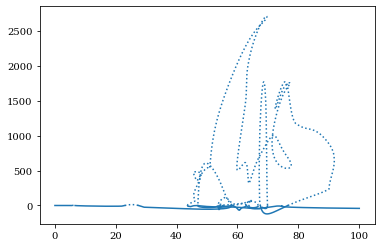

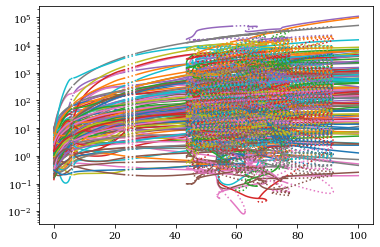

In [22]:
imp.reload(rmtchem)
n=128
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=int(0.5*nr)
seed=875
natoms=3
print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G,atoms=rmtchem.get_network(n,nr,na,natoms,True) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_array(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
m=(eta[::2]-nu[::2]).T.dot(nu[::2]-eta[::2])
print(len(lcc),np.linalg.matrix_rank(m))

X0=np.exp(-G)
start=timeit.default_timer()
Xs,epsilons,evals,bif,dxs=rmtchem.pseudoarclength_log(X0, eta, nu, k, XD1, XD2, 0, 100, ds=1e-2,  dsmax=1e-1, output=2,stop=False,sn_detect=False,hopf_detect=True,cond_detect=False)

stop=timeit.default_timer()
print('\n',stop-start)
plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]

for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls='-',color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls=':',color=colors[0])
plt.show()

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

27.404600158531366 0.9114244399607578
0.000052	0.000004	7645	57	lsoda	
Found oscillating state!
18.79062443319708


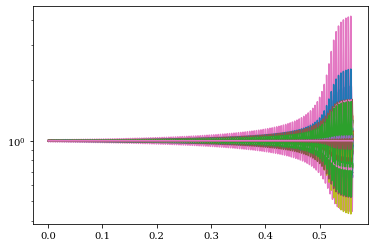

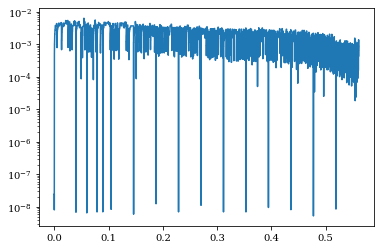

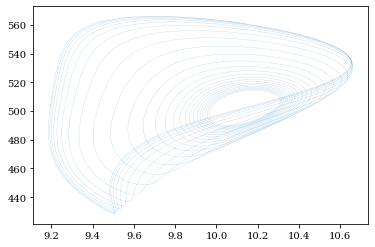

In [23]:
imp.reload(rmtchem)
import os
import warnings
warnings.simplefilter("ignore")

null_fd = os.open(os.devnull, os.O_RDWR)
os.dup2(null_fd, 1) #trick to suppress stdout from lsoda fortran calls

m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
epsilon0=27.4
m0=np.argmin(np.abs(epsilons-epsilon0))
X0=Xs[m0]
sd1=rmtchem.Sdot(rmtchem.rates(X0,eta,nu,k))
wd1=rmtchem.Wdot(X0, G, (1+epsilons[m0])*XD1, XD2)
epsilon=epsilons[m0]+1e-2
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilons[m0],np.max(np.real(evals[m0])))

start=timeit.default_timer()
ts,Xts,success,m1,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True,maxcycles=25)
stop=timeit.default_timer()
print(stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()
plt.yscale('log')
plt.plot(ts[:-1]/tscale,np.diff(ts)/dt)
plt.show()
plt.plot(Xts[0,m1:],Xts[1,m1:],linewidth=0.1)
plt.show()


2.17026e+01	-5.76650e-03	2.40973e-01	-2.16152e-02	115	1	9.21741e-16	
Hopf bifurcation!	21.702605
2.13208e+01	-8.64976e-03	4.14263e-01	-2.09888e-02	132	1	1.34472e-15	
Hopf bifurcation!	21.320783


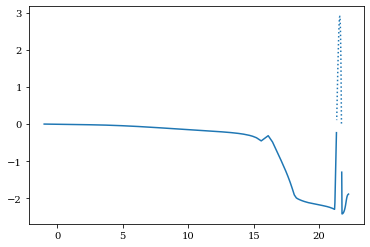

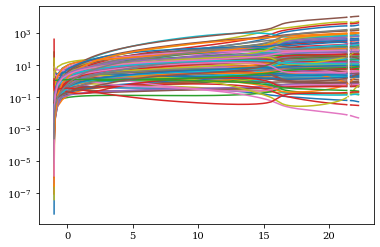

In [10]:
imp.reload(rmtchem)
Xs2,epsilons2,evals2,bif2,dxs2=rmtchem.pseudoarclength_log(Xts[:,-1], eta, nu, k, XD1, XD2, epsilon, 101, ds=-1e-4, dsmax=1e-1,output=2,stop=False,sn_detect=False,hopf_detect=False)
plt.figure()
inds1=np.where(np.max(np.real(evals2),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals2),axis=1)>=0)[0]

for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    plt.plot(epsilons2[inds],np.max(np.real(evals2),axis=1)[inds],ls='-',color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    plt.plot(epsilons2[inds],np.max(np.real(evals2),axis=1)[inds],ls=':',color=colors[0])
plt.show()

plt.figure()
inds1=np.where(np.max(np.real(evals2),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals2),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons2[inds],Xs2[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons2[inds],Xs2[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

In [1]:
np.save('data/sn/Xs.npy',Xs)
np.save('data/sn/epsilons.npy',epsilons)
np.save('data/sn/evals.npy',evals)
np.save('data/sn/ts.npy',ts)
np.save('data/sn/Xts.npy',Xts)

NameError: name 'np' is not defined

### sweep of seeds

128 310 12 0 211
127 124
7.56096e+01	7.59375e-02	9.03008e-01	8.36873e-02	888	1	4.44011e-11	
Hopf bifurcation!	75.609556
7.69663e+01	7.59375e-02	8.85746e-01	8.54255e-02	904	1	3.99684e-11	
Hopf bifurcation!	76.966257
1.00023e+02	7.59375e-02	9.88640e-01	7.68021e-02	1196	1	1.50594e-11	
 60.97056785109453


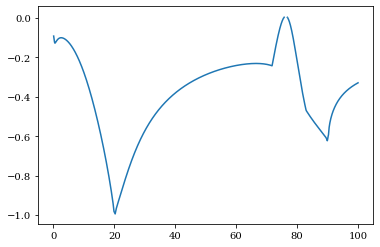

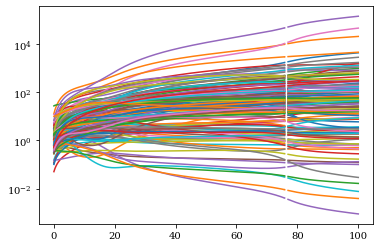

128 310 12 0 357
128 125
3.22192e+01	2.25000e-02	1.24512e-01	7.39078e-02	352	1	6.63359e-10	
Saddle-node bifurcation!	32.219215
3.23511e+01	2.25000e-02	2.75859e-01	-3.58448e-01	353	1	2.22621e-10	
Saddle-node bifurcation!	32.351055
1.00071e+02	7.59375e-02	9.80732e-01	7.74203e-02	1113	7	3.76485e-19	
 57.914339896989986


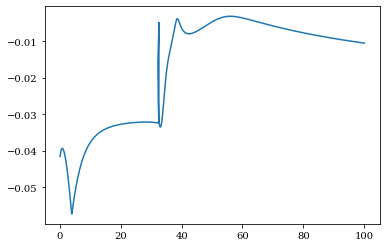

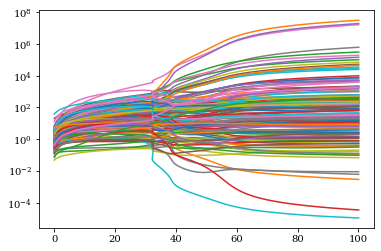

128 310 12 0 408
126 123
3.40996e+01	7.59375e-02	5.31912e-01	1.40096e-01	307	1	1.33942e-10	
Hopf bifurcation!	34.099627
3.42394e+01	7.59375e-02	5.29182e-01	1.39692e-01	308	1	1.33194e-10	
Hopf bifurcation!	34.239420
3.52957e+01	7.59375e-02	3.81522e-01	1.59671e-01	315	1	1.01374e-10	
Hopf bifurcation!	35.295688
3.59008e+01	7.59375e-02	3.74136e-01	2.06706e-01	318	1	6.52088e-11	
Hopf bifurcation!	35.900793
1.00044e+02	7.59375e-02	9.79890e-01	7.74728e-02	1081	1	5.25071e-15	
 53.776720551075414


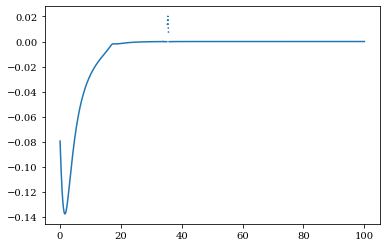

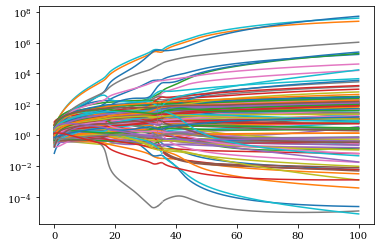

128 310 12 0 16
125 122
8.24767e+01	1.73415e-04	-1.72319e-01	2.26433e-03	985	1	5.58979e-14	
Saddle-node bifurcation!	82.476714
8.16649e+01	1.73415e-04	1.36946e-01	-3.84832e-04	1136	1	4.58249e-14		
Saddle-node bifurcation!	81.664886
1.00025e+02	7.59375e-02	9.92761e-01	7.64847e-02	1515	1	5.52097e-14	
 73.58993555791676


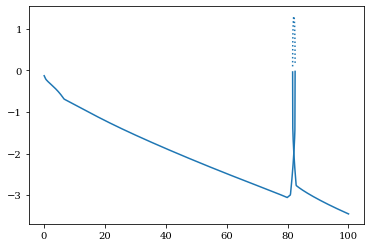

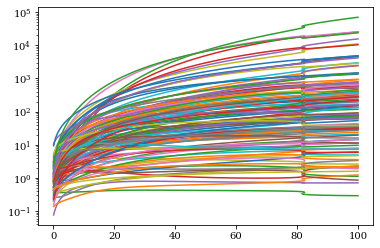

128 310 12 0 624
127 124
2.45258e+01	2.60123e-04	-9.96370e-02	7.30731e-04	257	1	1.52251e-09	
Saddle-node bifurcation!	24.525762
2.33024e+01	3.90184e-04	5.80096e-02	-1.12502e-02	398	1	1.45290e-09		
Saddle-node bifurcation!	23.302376
1.00033e+02	7.59375e-02	9.89054e-01	7.67674e-02	1420	1	2.78438e-12	
 72.01496781199239


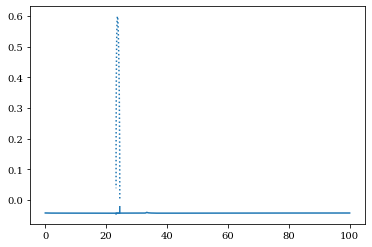

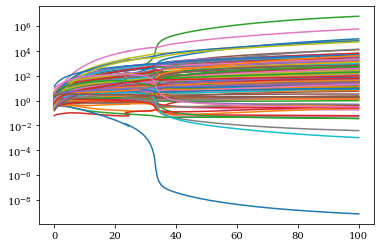

128 310 12 0 433
126 123
8.28799e+01	1.73415e-04	-1.05684e-01	6.47666e-04	959	1	1.55815e-14	
Saddle-node bifurcation!	82.879865
7.30401e+01	5.85277e-04	1.16675e-01	-2.28286e-03	1233	1	3.69704e-14		
Saddle-node bifurcation!	73.040140
1.00031e+02	7.59375e-02	9.87493e-01	7.68884e-02	1683	1	1.58287e-15	
 85.32198854815215


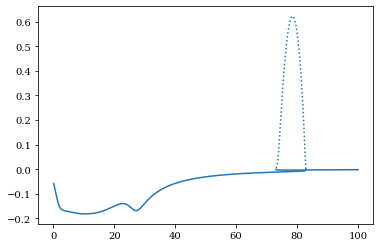

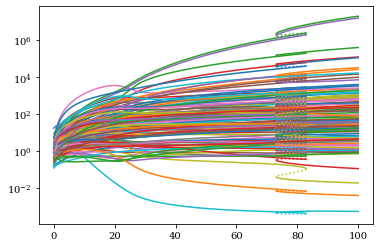

128 310 12 0 109
128 125
9.73034e+01	3.90184e-04	-1.25946e-01	5.40479e-04	1205	1	6.41937e-12	
Saddle-node bifurcation!	97.303441
8.60556e+01	2.60123e-04	1.87490e-01	-4.78744e-03	1479	1	6.17339e-12		
Saddle-node bifurcation!	86.055602
1.00062e+02	7.59375e-02	9.90389e-01	7.66669e-02	1790	1	1.21914e-11	
 90.23244355083443


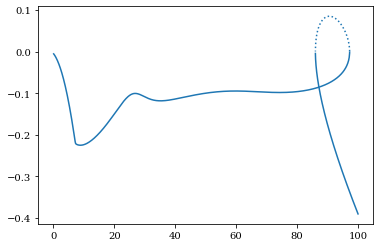

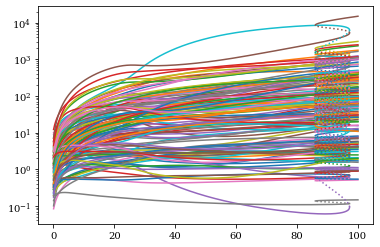

128 310 12 0 345
128 125
6.07677e+01	7.59375e-02	3.50771e-01	2.88176e-01	668	1	4.07929e-14	
Hopf bifurcation!	60.767679
6.31396e+01	7.59375e-02	4.95615e-01	1.47030e-01	681	1	8.88281e-15	
Hopf bifurcation!	63.139581
1.00001e+02	7.59375e-02	9.80371e-01	7.74424e-02	1131	1	1.83214e-16	
 58.712904053973034


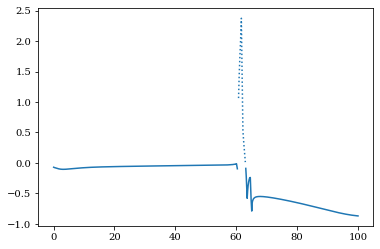

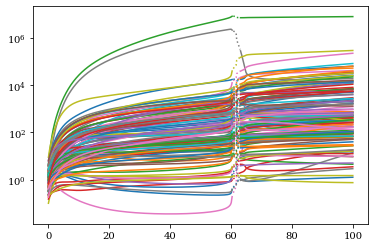

128 310 12 0 674
128 125
2.07831e+01	1.50000e-02	-8.02768e-02	6.39284e-02	180	1	1.23650e-12	
Saddle-node bifurcation!	20.783078
2.03422e+01	2.25000e-02	1.32438e-01	-6.45643e-03	190	1	9.44043e-13		
Saddle-node bifurcation!	20.342226
7.36713e+01	7.59375e-02	9.19679e-01	8.23092e-02	771	1	1.37414e-16	
Hopf bifurcation!	73.671318
7.37538e+01	7.59375e-02	9.18896e-01	8.23798e-02	772	1	1.37387e-16	
Hopf bifurcation!	73.753770
7.65897e+01	7.59375e-02	9.02839e-01	8.39433e-02	806	1	1.14565e-16	
Hopf bifurcation!	76.589675
7.66736e+01	7.59375e-02	9.02731e-01	8.39547e-02	807	1	1.13999e-16	
Hopf bifurcation!	76.673635
7.71775e+01	7.59375e-02	9.02671e-01	8.39815e-02	813	1	1.10717e-16	
Hopf bifurcation!	77.177505
8.10256e+01	7.59375e-02	9.10937e-01	8.32630e-02	859	1	9.08444e-17	
Hopf bifurcation!	81.025622
8.11089e+01	7.59375e-02	9.11104e-01	8.32476e-02	860	1	9.04860e-17	
Hopf bifurcation!	81.108851
8.24384e+01	7.59375e-02	9.13738e-01	8.30037e-02	876	1	8.50232e-17	
Hopf bifurcation!	82.438393
8.25214e

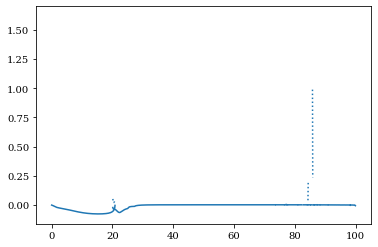

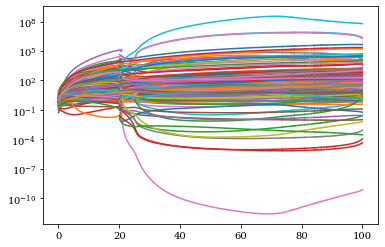

128 310 12 0 355
126 123
7.80509e+00	4.44444e-03	-5.43874e-02	1.09580e-01	77	1	1.42843e-09	
Saddle-node bifurcation!	7.805087
7.14956e+00	1.00000e-02	7.34682e-02	-3.65762e-02	101	1	8.35321e-10		
Saddle-node bifurcation!	7.149565
1.00036e+02	7.59375e-02	9.89631e-01	7.67215e-02	1239	1	3.31983e-12	
 57.65910078887828


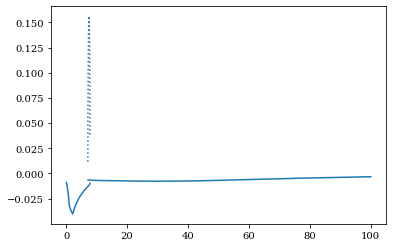

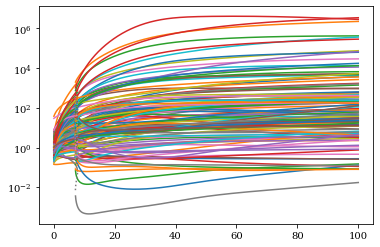

128 310 12 0 48
128 125
3.14232e+01	2.96296e-03	-1.44843e-01	1.02892e-02	296	1	2.14800e-13	
Saddle-node bifurcation!	31.423162
2.58063e+01	1.97531e-03	6.68272e-02	-4.18032e-02	410	1	3.01527e-13		
Saddle-node bifurcation!	25.806251
1.00057e+02	7.59375e-02	9.91417e-01	7.65830e-02	1423	1	1.72347e-14	
 72.63571504782885


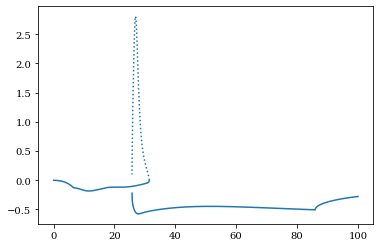

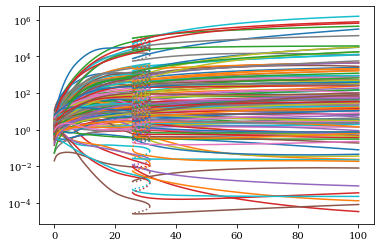

128 310 12 0 192
128 125
4.48021e+01	1.31687e-03	-1.98167e-01	5.57072e-03	524	1	4.90778e-10	
Saddle-node bifurcation!	44.802131
4.05486e+01	1.31687e-03	9.31761e-02	-2.55106e-02	660	1	7.52818e-10		
Saddle-node bifurcation!	40.548573
1.00068e+02	7.59375e-02	9.88409e-01	7.68143e-02	1506	1	6.72196e-11	
 77.3671748561319


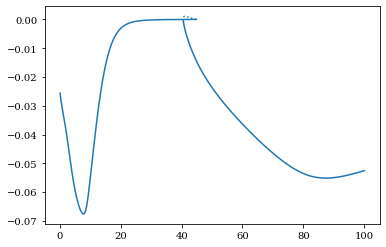

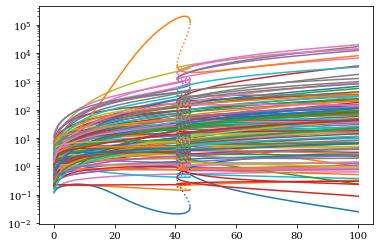

128 310 12 0 509
126 123
4.68117e+00	1.00000e-02	-1.24367e-01	3.68968e-02	60	1	1.33556e-08	
Saddle-node bifurcation!	4.681171
4.13873e+00	1.50000e-02	9.95174e-02	-2.29922e-02	73	1	7.52974e-09		
Saddle-node bifurcation!	4.138731
1.00076e+02	7.59375e-02	9.88091e-01	7.68374e-02	1203	3	1.43856e-17	
 60.27907442813739


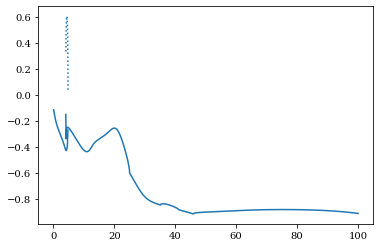

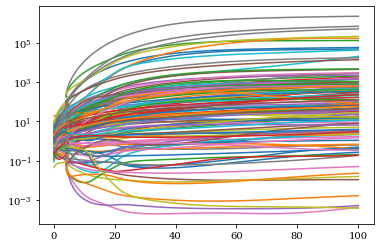

128 310 12 0 425
126 123
7.58597e+01	2.60123e-04	-1.63531e-01	1.13783e-03	859	1	1.72480e-16	
Saddle-node bifurcation!	75.859652
5.64459e+01	1.31687e-03	8.15086e-02	-2.59642e-02	1237	1	6.83078e-15		
Saddle-node bifurcation!	56.445927
1.00042e+02	7.59375e-02	9.93009e-01	7.64660e-02	1875	1	1.71031e-15	
 87.85408835788257


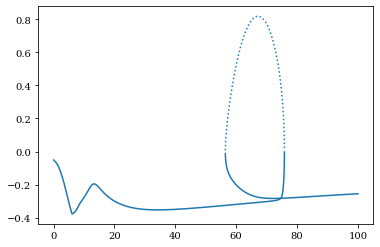

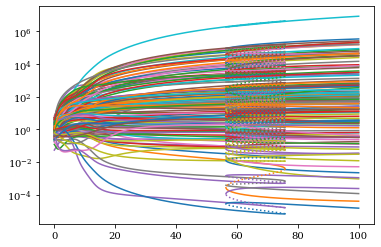

128 310 12 0 541
126 123
6.12080e+01	8.77915e-04	-9.62527e-02	2.36790e-02	645	1	1.93873e-13	
Saddle-node bifurcation!	61.208003
5.30914e+01	8.77915e-04	1.01463e-01	-1.65377e-03	842	1	1.28407e-12		
Saddle-node bifurcation!	53.091394
1.00013e+02	7.59375e-02	9.90767e-01	7.66363e-02	1534	1	4.29298e-14	
 79.75387284695171


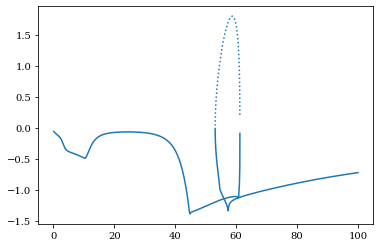

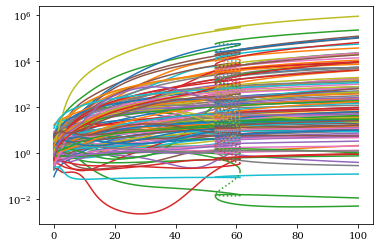

128 310 12 0 468
126 123
1.03615e+01	2.25000e-02	-6.89174e-02	6.93964e-02	87	1	9.43309e-10	
Saddle-node bifurcation!	10.361500
1.00083e+01	2.25000e-02	6.71865e-02	-7.27835e-02	92	1	6.04311e-11		
Saddle-node bifurcation!	10.008337
1.00061e+02	7.59375e-02	9.87864e-01	7.68626e-02	1626	22	1.49504e-21	
 110.0508364890702


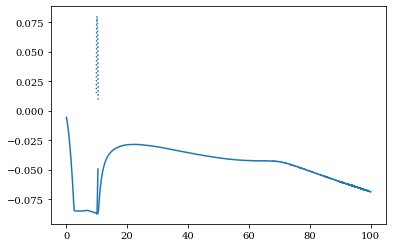

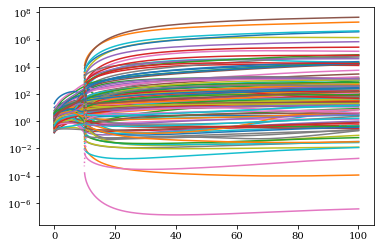

128 310 12 0 321
128 125
8.68290e+01	7.59375e-02	6.56070e-01	9.71549e-02	980	1	1.36087e-12	
Hopf bifurcation!	86.828967
8.70262e+01	5.85277e-04	-1.07313e-01	2.11042e-02	996	1	3.75654e-13	
Saddle-node bifurcation!	87.026174
8.11947e+01	1.50000e-02	4.99934e-01	-5.77980e-02	1164	1	1.89033e-12		
Saddle-node bifurcation!	81.194665
8.12838e+01	1.50000e-02	6.97542e-01	2.20451e-02	1168	1	5.54439e-12	
Hopf bifurcation!	81.283849
1.00032e+02	7.59375e-02	9.55766e-01	7.93447e-02	1424	1	4.35399e-11	
 78.10541911004111


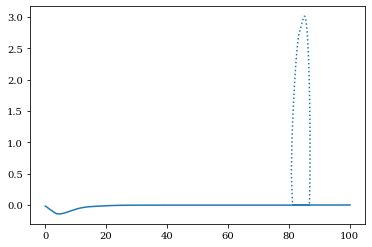

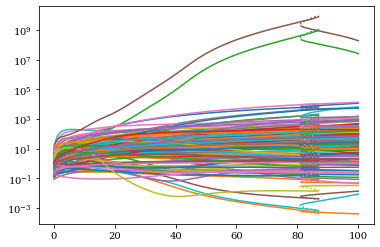

128 310 12 0 522
126 123
1.07334e+01	1.00000e-02	-8.00303e-02	2.89526e-03	93	1	2.36623e-10	
Saddle-node bifurcation!	10.733446
1.03193e+01	1.50000e-02	3.81143e-02	-2.07911e-02	103	1	4.54305e-11		
Saddle-node bifurcation!	10.319279
1.00027e+02	7.59375e-02	9.95279e-01	7.62933e-02	1201	5	1.58333e-18	
 58.20830671302974


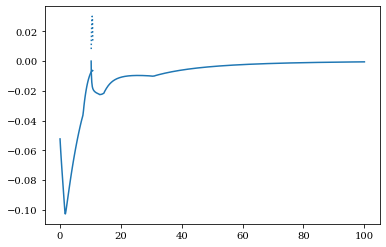

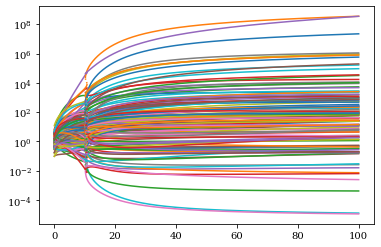

128 310 12 0 266
126 123
2.70889e+01	7.59375e-02	8.26659e-01	9.14368e-02	243	1	3.04352e-12	
Hopf bifurcation!	27.088928
3.27929e+01	6.66667e-03	-1.25688e-01	9.22742e-02	296	1	2.03303e-13	
Saddle-node bifurcation!	32.792927
3.20040e+01	4.44444e-03	9.73221e-02	-6.52086e-02	323	1	2.92943e-14		
Saddle-node bifurcation!	32.003998
1.00012e+02	7.59375e-02	9.72663e-01	7.80485e-02	1229	7	1.31077e-19	
 62.149213248165324


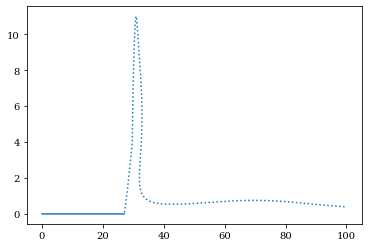

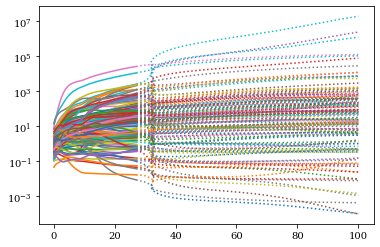

128 310 12 0 417
128 125
5.38838e+01	1.50000e-02	-7.58849e-02	2.53016e-02	579	1	2.09179e-13	
Saddle-node bifurcation!	53.883824
5.02895e+01	6.66667e-03	5.43435e-02	-6.94429e-02	623	1	8.25501e-14		
Saddle-node bifurcation!	50.289503
1.00009e+02	7.59375e-02	9.86672e-01	7.69523e-02	1270	3	9.12290e-18	
 66.61591259506531


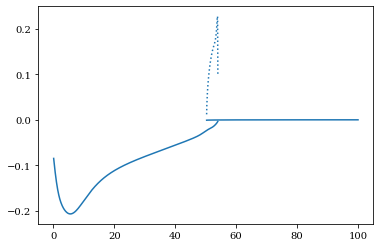

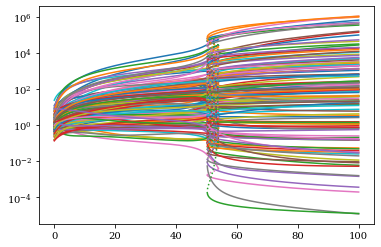

128 310 12 0 514
125 122
9.59379e+00	1.00000e-02	-6.39824e-02	1.85484e-01	93	1	2.92577e-09	
Saddle-node bifurcation!	9.593789
3.77288e+00	2.25000e-02	6.16766e-02	-8.35111e-02	158	1	1.24121e-11		
Saddle-node bifurcation!	3.772884
1.00070e+02	7.59375e-02	9.87927e-01	7.68567e-02	1276	5	7.69146e-24	
 68.45353777194396


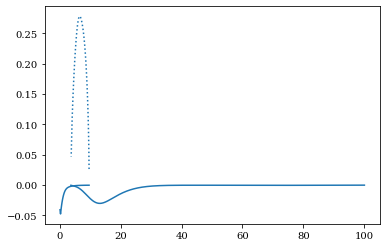

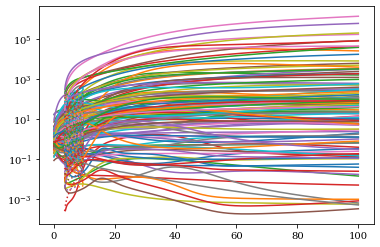

128 310 12 0 419
127 124
6.25073e+01	5.85277e-04	-1.23744e-01	3.98061e-03	719	1	1.64015e-14	
Saddle-node bifurcation!	62.507278
5.76243e+01	6.66667e-03	1.18735e-01	-8.66021e-03	873	1	2.03437e-13		
Saddle-node bifurcation!	57.624290
1.00002e+02	7.59375e-02	9.87581e-01	7.68810e-02	1438	1	6.51786e-14	
 76.24794087302871


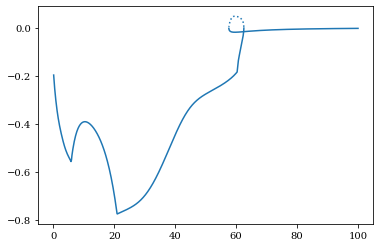

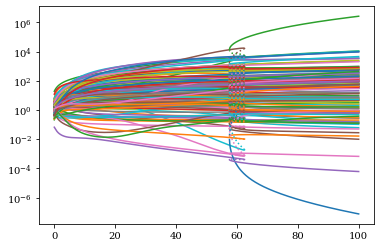

128 310 12 0 171
127 124
1.62070e+01	1.00000e-02	-1.76873e-01	1.32531e-01	147	1	3.00573e-12	
Saddle-node bifurcation!	16.206967
1.20334e+01	1.00000e-02	1.36170e-01	-2.19209e-02	216	1	2.15933e-13		
Saddle-node bifurcation!	12.033381
1.00045e+02	7.59375e-02	9.43607e-01	8.04873e-02	1240	4	3.91338e-19	
 69.71892448095605


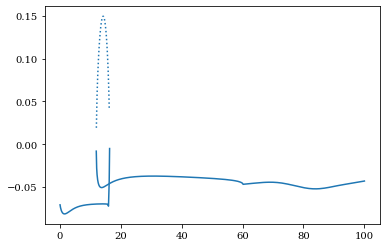

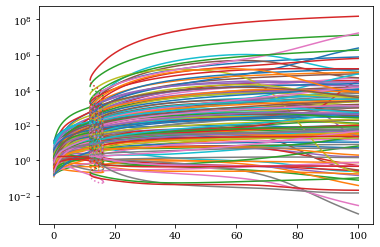

128 310 12 0 64
127 124
4.86733e+01	2.96296e-03	-1.40028e-01	1.19284e-02	480	1	3.13823e-13	
Saddle-node bifurcation!	48.673310
3.33307e+01	1.97531e-03	6.22291e-02	-9.82003e-02	711	1	8.11451e-13		
Saddle-node bifurcation!	33.330717
4.91249e+01	7.59375e-02	9.05909e-01	8.35372e-02	963	1	4.05665e-13	
Hopf bifurcation!	49.124875
1.00001e+02	7.59375e-02	9.88549e-01	7.68059e-02	1603	1	2.05431e-14	
 85.14466664381325


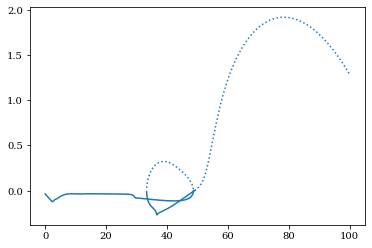

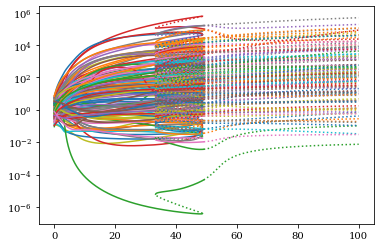

128 310 12 0 659
128 125
1.18916e+01	5.06250e-02	-1.57069e-01	5.22010e-02	96	1	1.27863e-10	
Saddle-node bifurcation!	11.891624
7.51959e+00	2.25000e-02	1.37686e-01	-9.61231e-02	126	1	1.71942e-09		
Saddle-node bifurcation!	7.519590
1.00017e+02	7.59375e-02	9.95076e-01	7.63087e-02	1232	2	6.77109e-18	
 64.08038080786355


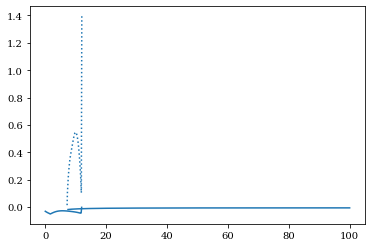

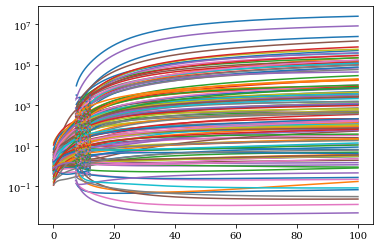

In [35]:
f=open('seeds30','r')
seeds=np.array(f.readlines(),dtype=int)
f.close()

for seed in seeds:
    imp.reload(rmtchem)
    n=128
    nr=int(0.5*n*np.log(n))
    nd=int(0.1*n)
    na=int(0.0*nr)
    natoms=3
    print(n,nr,nd,na,seed)

    np.random.seed(seed)
    eta,nu,k,G,atoms=rmtchem.get_network(n,nr,na,natoms,False) 
    row,col=np.where(eta[::2]-nu[::2]!=0)
    data=(eta[::2]-nu[::2])[row,col]
    A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
    adj=A.T.dot(A)
    g=nx.convert_matrix.from_scipy_sparse_array(adj)
    lcc=np.array(list(max(nx.connected_components(g), key=len)))
    n=len(lcc)
    eta=eta[:,lcc]
    nu=nu[:,lcc]
    G=G[lcc]
    d0=1e6
    d1min=0
    d1max=100
    XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
    m=(eta[::2]-nu[::2]).T.dot(nu[::2]-eta[::2])
    print(len(lcc),np.linalg.matrix_rank(m))
    
    X0=np.exp(-G)
    start=timeit.default_timer()
    Xs,epsilons,evals,bif,dxs=rmtchem.pseudoarclength_log(X0, eta, nu, k, XD1, XD2, 0, 100, ds=1e-2,  dsmax=1e-1, output=2,stop=False,sn_detect=False,hopf_detect=False,cond_detect=False)


    stop=timeit.default_timer()
    print('\n',stop-start)
    plt.figure()
    inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
    inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]

    for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
        plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls='-',color=colors[0])
    for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
        plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls=':',color=colors[0])
    plt.show()

    plt.figure()
    inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
    inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
    plt.yscale('log')
    for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
        for i in range(n):
            plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
    for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
        for i in range(n):
            plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])
    plt.show()

### Hopf bifurcations

64 133 6 33 25
1	3	
1	3	1	3	
274	132	
64 61
2.91300e+01	9.85261e-02	9.15188e-01	9.01180e-02	716	1	2.42882e-09	
Subcritical Hopf bifurcation!	29.130034
5.41773e+01	9.85261e-02	9.60451e-01	9.46240e-02	984	1	3.40579e-10	
Subcritical Hopf bifurcation!	54.177330
7.95420e+01	9.85261e-02	9.90606e-01	9.75950e-02	1247	1	1.20755e-10	
Supercritical Hopf bifurcation!	79.542026


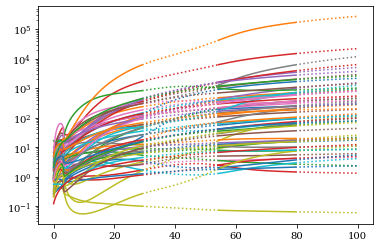

In [43]:
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=int(0.25*nr)
seed=25
natoms=3
print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G,atoms=rmtchem.get_network(n,nr,na,natoms,True) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
m=(eta[::2]-nu[::2]).T.dot(nu[::2]-eta[::2])
print(len(lcc),np.linalg.matrix_rank(m))

X0=np.exp(-G)
start=timeit.default_timer()
Xs,epsilons,evals,bif,dxs=rmtchem.pseudoarclength_log(X0, eta, nu, k, XD1, XD2, 0, 100, ds=1e-4, dsmax=1e-1,output=2,stop=False)

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

29.140034279109578 577.3724515105785 0.3003452263480314
0.000136	0.000003	53024	245	lsoda	
Found oscillating state!
True 81.33590200007893


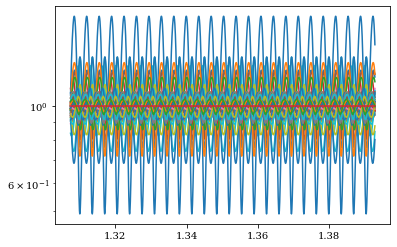

51050 54374


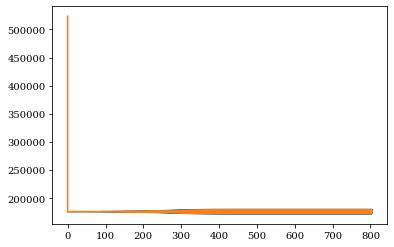

175837.34943759174 176131.9191662977 175837.3494376272 176130.39745503847 0.779534000941305 166.15386684715085


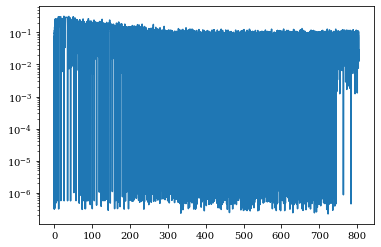

1


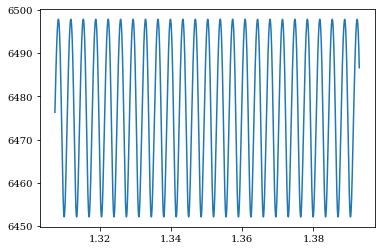

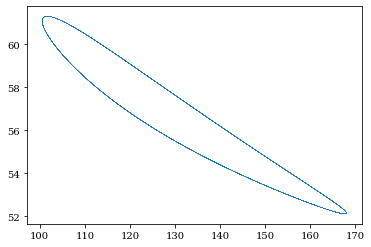

In [44]:
imp.reload(rmtchem)
m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
X0=Xs[m0]
sd1=rmtchem.Sdot(rmtchem.rates(X0,eta,nu,k))
wd1=rmtchem.Wdot(X0, G, (1+epsilons[m0])*XD1, XD2)
epsilon=epsilons[m0]+1e-2
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilon,tscale,dt)
start=timeit.default_timer()
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True,maxcycles=200)
m0=int(m0+9*(len(ts)-m0)/10)

stop=timeit.default_timer()
print(success,stop-start)

plt.yscale('log')
plt.plot(ts[m0:]/tscale,np.transpose(Xts)[m0:]/X0)
plt.show()

sd=[rmtchem.Sdot(rmtchem.rates(Xts[:,i],eta,nu,k)) for i in range(len(ts))]
wd=[rmtchem.Wdot(Xts[:,i],G,(1+epsilon)*XD1,XD2) for i in range(len(ts))]
print(m0,len(ts))
sd2=np.sum(np.diff(ts)[m0-1:]*sd[m0:])/np.sum(np.diff(ts)[m0-1:])
wd2=np.sum(np.diff(ts)[m0-1:]*wd[m0:])/ np.sum(np.diff(ts)[m0-1:])
dn1=np.sum(np.diff(ts)[m0-1:]*[np.linalg.norm((Xts[:,i]-X0)/X0) for i in range(m0,len(ts))])/ np.sum(np.diff(ts)[m0-1:])
dn2=np.sum(np.diff(ts)[m0-1:]*[np.linalg.norm(Xts[:,i]-X0) for i in range(m0,len(ts))])/ np.sum(np.diff(ts)[m0-1:])
plt.plot(ts,sd)
plt.plot(ts,wd)
plt.show()
print(sd1, sd2, wd1, wd2, dn1,dn2)

plt.yscale('log')
plt.plot(ts[:-1],np.diff(ts)/dt)
plt.show()
print(state)
plt.plot(ts[m0:]/tscale,np.linalg.norm(Xts,axis=0)[m0:])
plt.show()
plt.plot(Xts[0,m0:],Xts[1,m0:],linewidth=0.1)
plt.show()


In [45]:
np.save('data/hopf/Xs.npy',Xs)
np.save('data/hopf/epsilons.npy',epsilons)
np.save('data/hopf/evals.npy',evals)
np.save('data/hopf/ts.npy',ts)
np.save('data/hopf/Xts.npy',Xts)

### Chemical chaos 

64 133 6 66 402
1	3	
1	3	1	3	
9554	132	
5.59512e+01	9.85261e-02	9.80982e-01	1.00374e-01	644	1	4.92730e-14	
Supercritical Hopf bifurcation!	55.951172


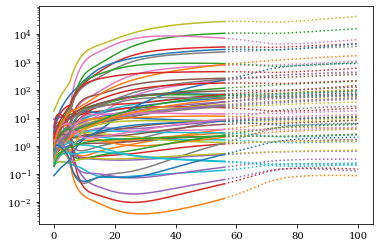

In [46]:
imp.reload(rmtchem)
n=64
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=int(0.5*nr)
natoms=5
seed=402
natoms=5
print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G,atoms=rmtchem.get_network(n,nr,na,natoms,True) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
start=timeit.default_timer()

Xs,epsilons,evals,bif,dxs=rmtchem.pseudoarclength_log(X0, eta, nu, k, XD1, XD2, d1min,d1max,ds=1e-4, dsmax=1e-1,output=2,stop=False)

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

90.95384375070171 1.4903952591297285
0.000214	0.000002	49134	24	lsoda	Unexpected istate in LSODA.
Found oscillating state!
94.09869565884583


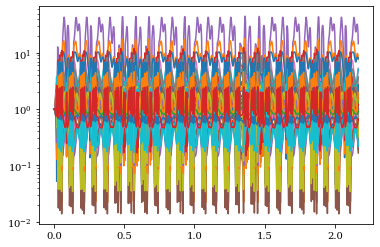

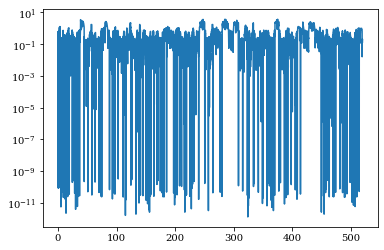

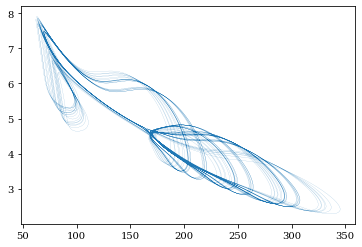

In [47]:
imp.reload(rmtchem)
import os
import warnings
warnings.simplefilter("ignore")

null_fd = os.open(os.devnull, os.O_RDWR)
os.dup2(null_fd, 1) #trick to suppress stdout from lsoda fortran calls

m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
epsilon0=91
m0=np.argmin(np.abs(epsilons-epsilon0))
X0=Xs[m0]
sd1=rmtchem.Sdot(rmtchem.rates(X0,eta,nu,k))
wd1=rmtchem.Wdot(X0, G, (1+epsilons[m0])*XD1, XD2)
epsilon=epsilons[m0]+1e-1
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilons[m0],np.max(np.real(evals[m0])))

start=timeit.default_timer()
ts,Xts,success,m1,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True,maxcycles=25)
stop=timeit.default_timer()
print(stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()
plt.yscale('log')
plt.plot(ts[:-1],np.diff(ts)/dt)
plt.show()
plt.plot(Xts[0,m1:],Xts[1,m1:],linewidth=0.1)
plt.show()


20 57.85404924427026 0.00012097183746864293


/Users/zack/opt/anaconda3/envs/cantera_env/lib/python3.7/site-packages/scipy/integrate/_ode.py:1351: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  self.messages.get(istate, unexpected_istate_msg)))


/Users/zack/Documents/rmtchem/rmtchem.py:131: RuntimeWarning: divide by zero encountered in true_divide
  dt=np.min([np.mean(10/tscales[tinds[:-1]]),100*dt0,ts[-1]/2,dtmax])


0.014190	0.000209	5850	99	irk  	Unexpected istate in LSODA.
Found oscillating state!
True 7.0127434910000375


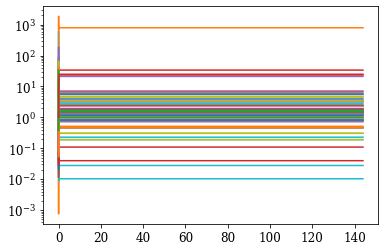

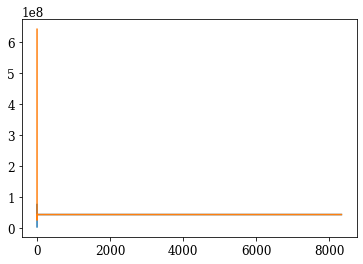

2678823.1087422688 42635553.72898769 634193247.0682617 42635553.72896941


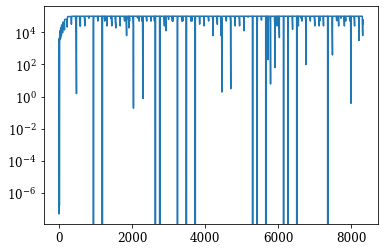

1


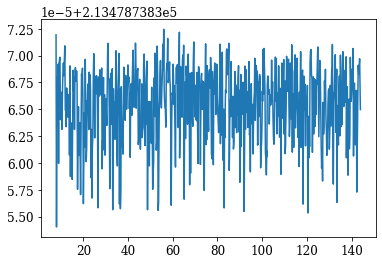

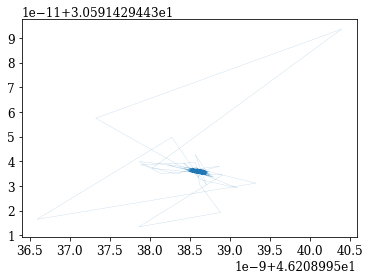

In [42]:
imp.reload(rmtchem)
m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
X0=Xs[m0]
epsilon=20
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilon,tscale,dt)
start=timeit.default_timer()
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True)

stop=timeit.default_timer()
print(success,stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()
sd=[rmtchem.Sdot(rmtchem.rates(Xts[:,i],eta,nu,k)) for i in range(len(ts))]
wd=[rmtchem.Wdot(Xts[:,i],G,(1+epsilon)*XD1,XD2) for i in range(len(ts))]
sd1=rmtchem.Sdot(rmtchem.rates(X0,eta,nu,k))
wd1=rmtchem.Wdot(X0, G, (1+epsilon-1e-1)*XD1, XD2)
sd2=np.sum(np.diff(ts)[m0-1:]*sd[m0:])/np.sum(np.diff(ts)[m0-1:])
wd2=np.sum(np.diff(ts)[m0-1:]*wd[m0:])/ np.sum(np.diff(ts)[m0-1:])
plt.plot(ts,sd)
plt.plot(ts,wd)
plt.show()
print(sd1, sd2, wd1, wd2)

plt.yscale('log')
plt.plot(ts[:-1],np.diff(ts)/dt)
plt.show()
print(state)
plt.plot(ts[m0:]/tscale,np.linalg.norm(Xts,axis=0)[m0:])
plt.show()
plt.plot(Xts[0,m0:],Xts[1,m0:],linewidth=0.1)
plt.show()


/Users/zack/opt/anaconda3/envs/cantera_env/lib/python3.7/site-packages/scipy/integrate/_ode.py:1351: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  self.messages.get(istate, unexpected_istate_msg)))


0.713588	0.286412	4941	11	irk  	Unexpected istate in LSODA.
Failed to find state before maxtime 578.5404924427025


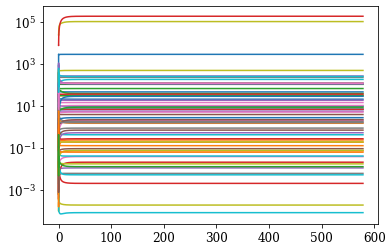

/Users/zack/opt/anaconda3/envs/cantera_env/lib/python3.7/site-packages/scipy/integrate/_ode.py:1351: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  self.messages.get(istate, unexpected_istate_msg)))


0.350831	0.175415	471876	0	irk  	Unexpected istate in LSODA.
Found steady state!
5.262462870665838 True


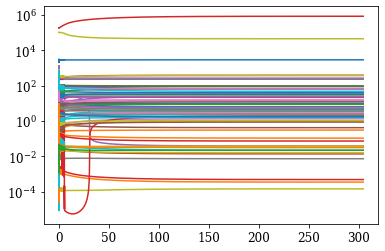

In [43]:
imp.reload(rmtchem)
np.random.seed(1)
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e1*tscale,10*dt,output=True,cont=True)
plt.yscale('log')
plt.plot(ts,np.transpose(Xts))
plt.show()
ts,Xts,success,m0,state=rmtchem.integrate(Xts[:,-1]*(1+1e-2*(0.5-np.random.random(size=len(X0)))),eta,nu,k,(1+epsilon)*XD1,XD2,1e1*tscale,dt,output=True,cont=False,maxsteps=1e7)
print(ts[-1]/tscale,success)
plt.yscale('log')
plt.plot(ts,np.transpose(Xts))
plt.show()

In [44]:
success,solx=rmtchem.steady(Xts[:,-1],eta,nu,k,(1+epsilon)*XD1,XD2)
print(success,np.linalg.norm((solx-Xts[:,-1])/solx))
ev,evecs=np.linalg.eig(rmtchem.jac(0,solx,eta,nu,k,(1+epsilon)*XD1,XD2))
print(ev[np.argmax(np.real(ev))])

True 0.0
(-0.022855819914751975+0j)


0.365176	1.000000e-02	1808	
Subcritical Hopf bifurcation!		36.517578
0.366579	4.882813e-06	1951	
Saddle-node bifurcation!	36.657866	4.882813e-06	1	1	0.000657	4.306462	4	4	3	
0.061400	-1.000000e-02	1387	
Subcritical Hopf bifurcation!		6.140000
0.061388	-6.103516e-07	1406	
Saddle-node bifurcation!	6.138784	-6.103516e-07	1	1	0.000000	45.493017	2	2	1	
0.366579	4.882813e-06	4866	
Saddle-node bifurcation!	36.657883	4.882813e-06	1	1	0.000554	3.864281	3	3	4	
0.365130	-2.500000e-03	4997	
Subcritical Hopf bifurcation!		36.512966


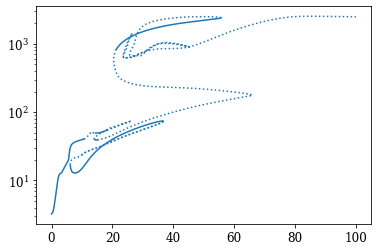

In [45]:
imp.reload(rmtchem)
X2s,epsilon2s,eval2s,bif2=rmtchem.quasistatic(solx, eta, nu, k, XD1, XD2, d1min,d1max,epsilon,1e-2,output=2,stepsmax=5000,stop=False)
X3s,epsilon3s,eval3s,bif3=rmtchem.quasistatic(solx, eta, nu, k, XD1, XD2, d1min,d1max,epsilon,-1e-2,output=2,stepsmax=5000,stop=False)


plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])
        
inds1=np.where(np.max(np.real(eval2s),axis=1)<0)[0]
inds2=np.where(np.max(np.real(eval2s),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon2s[inds],X2s[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon2s[inds],X2s[inds,i],ls=':',color=colors[np.mod(i,len(colors))])
        
inds1=np.where(np.max(np.real(eval3s),axis=1)<0)[0]
inds2=np.where(np.max(np.real(eval3s),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon3s[inds],X3s[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon3s[inds],X3s[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

In [46]:
np.save('data/chaos/Xs1.npy',Xs)
np.save('data/chaos/epsilons1.npy',epsilons)
np.save('data/chaos/evals1.npy',evals)
np.save('data/chaos/Xs2.npy',X2s)
np.save('data/chaos/epsilons2.npy',epsilon2s)
np.save('data/chaos/evals2.npy',eval2s)
np.save('data/chaos/Xs3.npy',X3s)
np.save('data/chaos/epsilons3.npy',epsilon3s)
np.save('data/chaos/evals3.npy',eval3s)

60 57.85404924427026 2.2959410919206036e-05


/Users/zack/opt/anaconda3/envs/cantera_env/lib/python3.7/site-packages/scipy/integrate/_ode.py:1351: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  self.messages.get(istate, unexpected_istate_msg)))


/Users/zack/Documents/rmtchem/rmtchem.py:131: RuntimeWarning: divide by zero encountered in true_divide
  dt=np.min([np.mean(10/tscales[tinds[:-1]]),100*dt0,ts[-1]/2,dtmax])


0.908137	0.063144	512069	149	lsoda	expected istate in LSODA.A.
Found oscillating state!
0.971281	0.062662	524904	197	lsoda	
Failed to find state before maxtime 2
True 663.6959975749996


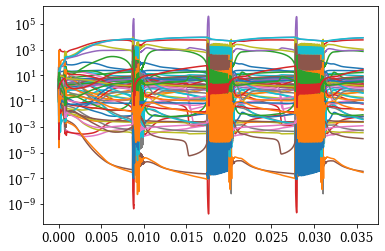

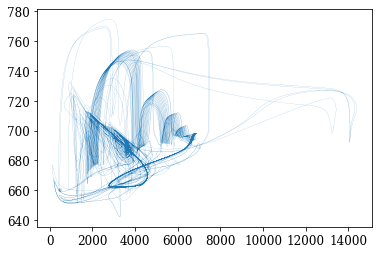

In [92]:
imp.reload(rmtchem)

Xs=np.load('data/chaos/Xs1.npy')
epsilons=np.load('data/chaos/epsilons1.npy')
evals=np.load('data/chaos/evals1.npy')

m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
X0=Xs[m0]
epsilon=60
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))

dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilon,tscale,dt)
start=timeit.default_timer()

ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2, 2,dt,output=True,cont=True)
stop=timeit.default_timer()
print(success,stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()

ind1=0
ind2=7
tmax=ts[-1]
tinds=np.where(ts>tmax/2)[0]
plt.plot(Xts[ind1,tinds],Xts[ind2,tinds],zorder=-1,linewidth=0.1,alpha=1.0)
plt.show()


In [117]:
np.save('data/chaos/ts.npy',ts[tinds[::2]])
np.save('data/chaos/Xts.npy',np.array([Xts[ind1,tinds[::2]],Xts[ind2,tinds[::2]]]))

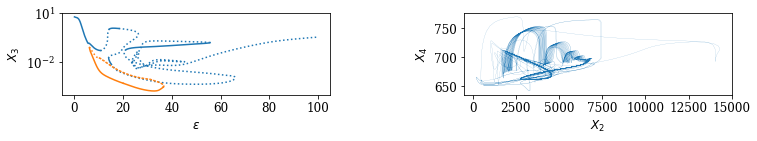

In [118]:
Xs=np.load('data/chaos/Xs1.npy')
epsilons=np.load('data/chaos/epsilons1.npy')
evals=np.load('data/chaos/evals1.npy')
Xs2=np.load('data/chaos/Xs2.npy')
epsilons2=np.load('data/chaos/epsilons2.npy')
evals2=np.load('data/chaos/evals2.npy')
Xs3=np.load('data/chaos/Xs3.npy')
epsilons3=np.load('data/chaos/epsilons3.npy')
evals3=np.load('data/chaos/evals3.npy')
ts=np.load('data/chaos/ts.npy')
Xts=np.load('data/chaos/Xts.npy')
m=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
tmax=2*np.pi/(np.imag(evals[m,np.argmax(np.real(evals[m]))]))*500

lst=range(n)
lst=[3]

plt.subplots(1,2,figsize=(12,1.5))

plt.subplot(1,2,1)

plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$X_3$')
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[0])

inds1=np.where(np.max(np.real(evals2),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals2),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons2[inds],Xs2[inds,i],color=colors[1])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons2[inds],Xs2[inds,i],ls=':',color=colors[1])

inds1=np.where(np.max(np.real(evals3),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals3),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons3[inds],Xs3[inds,i],color=colors[1])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons3[inds],Xs3[inds,i],ls=':',color=colors[1])

ax=plt.subplot(1,2,2)
ax.set_rasterization_zorder(0)
plt.xlabel(r'$X_2$')
plt.ylabel(r'$X_4$')

plt.plot(Xts[0],Xts[1],zorder=-1,linewidth=0.1,alpha=1.0)

plt.subplots_adjust(wspace=0.5,hspace=0.0)
plt.savefig('plots/fig3c.pdf',dpi=300)
plt.show()

### Empirical reaction network stoichiometry

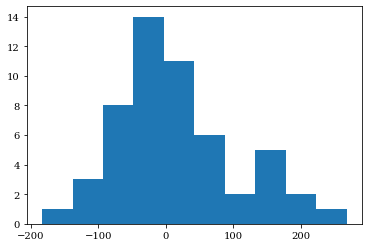

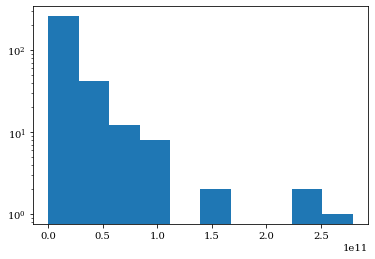

In [82]:
gas=ct.Solution('gri30.cti')
plt.hist(gas.standard_gibbs_RT)
plt.show()
plt.yscale('log')
plt.hist(gas.forward_rate_constants)
plt.show()

In [84]:
gas.forward_rate_constants.shape

(325,)

In [85]:
gas.standard_gibbs_RT.shape

(53,)

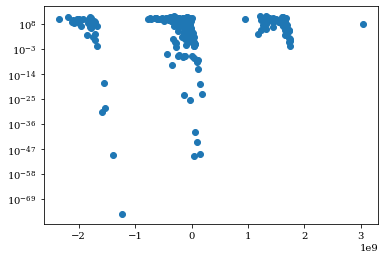

In [93]:
plt.scatter(gas.delta_gibbs,gas.forward_rate_constants)
plt.yscale('log')

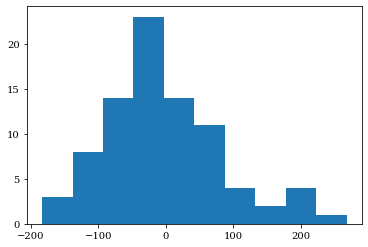

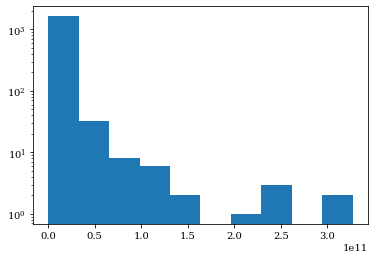

In [95]:
gas=ct.Solution('data/pyrolysis.cti')
plt.hist(gas.standard_gibbs_RT)
plt.show()
indices=np.where(gas.forward_rate_constants<1e15)[0]
plt.yscale('log')
plt.hist(gas.forward_rate_constants[indices])
plt.show()

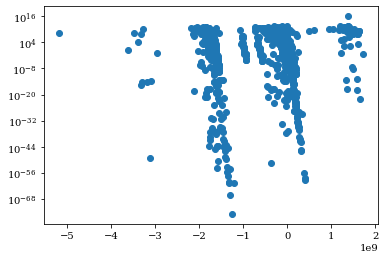

In [98]:
plt.scatter(gas.delta_gibbs,gas.forward_rate_constants)
plt.yscale('log')

### Hard chemostat, faster and better conditioned, but still difficult...

In [56]:
from rmtchem import jac
from rmtchem import func
from scipy.linalg import null_space
from scipy.optimize import root
from scipy.linalg import eig
from scipy.optimize import newton
ds=1e-3
dsmax=1e-1
dsmin=1e-16
depmin=1e-6
itmax=1e5
output=True
stop=True
tol=1e-8
stol=1e-4
ep0=0
ep1=100
if True:
    def step(x,dx,x_last,ds):
        X=np.zeros(n)
        inds=np.where(XD2>0)[0]
        inds2=np.setdiff1d(np.arange(n),inds)
        X[inds2]=x[:-1]
        ep=x[-1]
        X[inds]=(1+ep)*XD1[inds]/XD2[inds]

        f=func(t,X,eta,nu,k,(1+ep)*XD1,XD2)[inds2]
        ps=(np.log(x[:-1])-np.log(x_last[:-1])).dot(dx[:-1])/n+(x[-1]-x_last[-1])*dx[-1]-ds
        return np.concatenate([f,[ps]])

    def step_jac(x,dx,x_last,ds):
        X=np.zeros(n)
        inds=np.where(XD2>0)[0]
        inds2=np.setdiff1d(np.arange(n),inds)
        X[inds2]=x[:-1]
        ep=x[-1]
        X[inds]=(1+ep)*XD1[inds]/XD2[inds]

        a=jac(t,X,eta,nu,k,(1+ep)*XD1,XD2)
        b=a[inds2,:][:,inds].dot(X[inds])
        A=np.hstack([a[inds2,:][:,inds2],b[:,np.newaxis]])
        c=dx[:-1]/x[:-1]/n
        d=np.array([dx[-1]])
        B=np.hstack([c,d])

        return np.vstack([A,B])

    def sn(ep,X_last):
        sol=root(lambda X:func(0,X,eta,nu,k,(1+ep)*XD1,XD2),x0=X_last, method='hybr', options={'xtol':tol,'diag':1/X_last})
        X=sol.x
        a=jac(t,X,eta,nu,k,(1+ep)*XD1,XD2)
        evs,evals=np.linalg.eig(a)
        ind=np.argmin(np.abs(evs))
        return np.real(evs[ind])

    start=timeit.default_timer()
    t=0
    X=X0.copy()
    ep=ep0
    n=len(XD1)
    inds=np.where(XD2>0)[0]
    nd=len(inds)
    inds2=np.setdiff1d(np.arange(n),inds)
    X[inds]=(1+ep)*XD1[inds]/XD2[inds]
    x_last=np.concatenate([X[inds2],[ep0]])

    a=jac(t,X,eta,nu,k,(1+ep)*XD1,XD2)
    b=a[inds2,:][:,inds].dot(X[inds])
    A=np.hstack([a[inds2,:][:,inds2],b[:,np.newaxis]])
    ns=null_space(A)
    dx=ns[:,0]
    if dx[-1]<0:
        dx=-dx

    Xs=[]
    eps=[]
    sols=[]
    evals=[]
    count=0
    csuc=0
    bif=0
    dep=0

    try:
        while ep<ep1 and count<itmax:
            count=count+1
            if output>0:
                print('%.5f\t%.5f\t%.5f\t%.5f\t%i\t%i\t'%(ep,ds,dx[-1],dep,count, null_space(A).shape[-1]),end='\r')

            scales=np.concatenate([1/X[inds2],[1.0]])

            mat=step_jac(x_last,dx,x_last,ds)
            ev,evecs=np.linalg.eig(mat)
            test1=np.abs(ev[np.argmin(np.abs(ev))])
            test2=np.abs(ev[np.argmax(np.abs(ev))])
            b=np.zeros(len(x_last))
            b[-1]=ds
            xpred=x_last+np.linalg.solve(mat,b)
            if output>0:
                print('%.5f\t%.5f\t%.5f\t%.5f\t%i\t%i\t%.5e\t'%(ep,ds,dx[-1],dep,count, null_space(A).shape[-1],test1/test2),end='\r')

            sol=root(step,x0=xpred, jac=step_jac, args=(dx,x_last,ds), method='hybr', options={'xtol':tol,'diag':scales})

            if sol.success:
                csuc=csuc+1
                X[inds2]=sol.x[:-1]
                ep=sol.x[-1]
                X[inds]=(1+ep)*XD1[inds]/XD2[inds]
                ev,lvec,rvec=eig(jac(0,X,eta,nu,k,(1+ep)*XD1, XD2)[inds2,:][:,inds2],left=True,right=True)
                x_last=sol.x.copy()

                eps=eps+[ep]
                Xs=Xs+[X.copy()]
                evals=evals+[ev]
                sols=sols+[sol]

                if len(eps)>3 and np.sign(np.diff(eps)[-1])!=np.sign(np.diff(eps)[-2]):
                    if output>2:
                        print('\nTrying to find saddle-node\t%.6f'%(ep),end='')
                    try:
                        sep,r=newton(sn,x0=ep,args=[X],full_output=True,tol=stol)

                        bif=2
                        if output>1:
                            print('\nSaddle-node bifurcation!\t%.6f'%(sep))
                        if stop:
                            break
                    except RuntimeError:
                        bif=-1
                        print('\nFailed to converge at SN!')
                        break
                elif len(evals)>2 and np.abs(np.count_nonzero(np.real(evals[-1])>0) - np.count_nonzero(np.real(evals[-2])>0))>=2:
                    if output>2:
                        print('\nTrying to find Hopf\t%.6f'%(ep))
                    ind=np.argmin(np.abs(np.real(ev)))
                    omega=np.imag(ev[ind])

                    q=rvec[:,ind]
                    p=lvec[:,ind]/np.vdot(rvec[:,ind],lvec[:,ind])
                    if omega<0:
                        omega=-omega
                        q=q.conjugate()
                        p=p.conjugate()
                    l=lcoeff(0,X,eta,nu,k,(1+ep)*XD1,XD2,q,p,omega)
                    if l<0:
                        bif=1
                        if output>1:
                            print('\nSupercritical Hopf bifurcation!\t%.6f'%(ep))
                        if stop:
                            break
                    else:
                        bif=3
                        if output>1:
                            print('\nSubcritical Hopf bifurcation!\t%.6f'%(ep))
                        if stop:
                            break

                # dx=(sol.x-x_last)/ds
                a=jac(t,X,eta,nu,k,(1+ep)*XD1,XD2)
                b=a[inds2,:][:,inds].dot(X[inds])
                A=np.hstack([a[inds2,:][:,inds2],b[:,np.newaxis]])
                ns=null_space(A)
                dx=np.sum(ns.T.dot(dx)*ns,axis=1)

                if len(eps)>1:
                    dep=np.diff(eps)[-1]
                    if np.abs(dep) < depmin:
                        print('Failed to converge!\t%.6f'%(ep))
                        bif=-1
                        break
                dx=dx/np.linalg.norm(dx)

                if csuc>10 and sol.nfev < 1000 and ds*1.5<=dsmax:
                    ds=ds*1.5
                    csuc=0
            else:
                if ds/1.5>=dsmin:
                    ds=ds/1.5
                    csuc=0
                else:
                    print('Failed to converge!\t%.6f'%(ep))
                    bif=-1
                    break
    except KeyboardInterrupt:
        print('\nKeyboard interrupt')
        bif=-1



ValueError: x and y must have same first dimension, but have shapes (2,) and (10, 64)

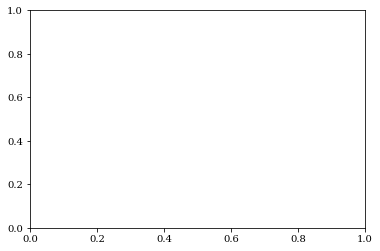

In [58]:
plt.plot(epsilons,Xs)